# English - Alice in wonderland

## Data preparation

In [1]:
from importlib import reload
import os

In [2]:
import preprocessor
preprocessor = reload(preprocessor)


pp = preprocessor.Preprocessor("data/original/alice_in_wonderland.txt", "eng")
cleaned_corpus = pp.process()
pp.split(cleaned_corpus)

118597 29650


## Subword segmentation

In [3]:
import sentpiece
sentpiece = reload(sentpiece)


NUM_CHARS = 100
TRAIN_DATA_PATH = "data/processed/eng_train.txt"
MODEL_NAME = "eng_model_sml"
SEG_DATA_PATH = "eng_sml.txt"


sentpiece.train_model(TRAIN_DATA_PATH, MODEL_NAME, NUM_CHARS)

In [4]:
!mv $MODEL_NAME* spm_models/

In [5]:
sentpiece.segmentation(TRAIN_DATA_PATH, MODEL_NAME, SEG_DATA_PATH)

## Train LM

In [18]:
TRAIN_SEG_DATA_PATH = "data/segmented/eng_sml.txt"
NUM_LAYERS = 40
CLASS = 9999
BPTT = 3


!bash train_script.sh $TRAIN_SEG_DATA_PATH "data/processed/eng_test.txt" $NUM_LAYERS $CLASS $BPTT

rm: cannot remove 'rnnlm/models/model': No such file or directory
rm: cannot remove 'rnnlm/models/model.output.txt': No such file or directory
debug mode: 2
train file: data/segmented/eng_sml.txt
valid file: data/processed/eng_test.txt
class size: 9999
Hidden layer size: 40
BPTT: 3
Rand seed: 1
rnnlm file: model
Starting training using file data/segmented/eng_sml.txt
Vocab size: 98
Words in train file: 70003
Iter:   0	Alpha: 0.100000	   TRAIN entropy: 4.9914    Words/sec: 1226.2   VALID entropy: 11.5537
Iter:   1	Alpha: 0.100000	   TRAIN entropy: 4.1096    Words/sec: 1382.2   VALID entropy: 12.4125
Iter:   2	Alpha: 0.050000	   TRAIN entropy: 4.0804    Words/sec: 1380.0   VALID entropy: 12.5771

real	2m43.524s
user	2m42.983s
sys	0m0.176s


In [19]:
MODEL_OUTPUT = MODEL_NAME + ".output.txt"

!mv model $MODEL_NAME
!mv model.output.txt $MODEL_OUTPUT

!mv $MODEL_NAME $MODEL_OUTPUT rnnlm_models/

## Data generation

In [21]:
GEN_DATA_PATH = "data/generated/eng_model_sml/"
MODEL_PATH = f"./rnnlm_models/{MODEL_NAME}"

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

^C


In [22]:
# Decoding generated texts

sentpiece.desegmentation("data/generated/eng_model_sml/100.txt", "eng_model_chr")

# Bengali

In [1]:
from importlib import reload
import os

In [2]:
import preprocessor
preprocessor = reload(preprocessor)


pp = preprocessor.Preprocessor("data/original/bengali_corpus.txt", "bng")
cleaned_corpus = pp.process()
pp.split(cleaned_corpus)

10861 2716


## Subword segmentation

In [14]:
import sentpiece
sentpiece = reload(sentpiece)

In [19]:
TRAIN_DATA_PATH = "data/processed/bng_train.txt"
TEST_DATA_PATH = "data/processed/bng_test.txt"
models, test_models = [], []
seg_train_path, seg_test_path = [], []
start=100
stop=150
step=50

for vocab_size in range(start, stop, step):
    train_model_name = "bng_train_"+str(vocab_size)
    test_model_name = "bng_test_"+str(vocab_size)
    tr_seg_data_path = f"bng_tr_wd_{str(vocab_size)}.txt"
    te_seg_data_path = f"bng_te_wd_{str(vocab_size)}.txt"
    
    sentpiece.train_model(TRAIN_DATA_PATH, train_model_name, vocab_size, lang="bng")
    models.append(train_model_name)
    seg_train_path.append(tr_seg_data_path)
    
    sentpiece.train_model(TEST_DATA_PATH, test_model_name, vocab_size, lang="bng")
    test_models.append(test_model_name)
    seg_test_path.append(te_seg_data_path)
    

In [5]:
import shutil, glob, os

for model in models+test_models:
    for file in glob.glob(f'{model}*'):
        cwd = os.getcwd() 
        src = cwd
        dst = cwd + "/spm_models/"
        shutil.move(os.path.join(src, file), os.path.join(dst, file))

In [6]:
for model, seg_path in zip(models,seg_train_path):
    sentpiece.segmentation(TRAIN_DATA_PATH, model, seg_path)

for model, seg_path in zip(test_models,seg_test_path):
    sentpiece.segmentation(TEST_DATA_PATH, model, seg_path)

In [29]:
## a snippet of generated files
selected_files = ["data/segmented/bng_tr_chr_50.txt", "data/segmented/bng_tr_chr_100.txt", "data/segmented/bng_tr_wd_1500.txt"]
for path in selected_files:
    with open(path) as f:
        data = f.read()[:150]
        print(f"{path[path.rfind('_')+1:]} : {data}")
        print("\n")

50.txt : ▁ য ত ্ ত স ব ▁ প া প ন ▁ শ া ল া র ▁ ফ া জ ল া ম ী ▁ প া প ন ▁ শ া ল া ▁ র ে ▁ র ি ম া ন ্ ড ে ▁ ন ে ও য ় া ▁ দ র ক া র জ ি ল ্ ল ু র ▁ র হ ম া ন ▁ 


100.txt : ▁য ত ্ ত স ব ▁প া প ন ▁শ াল ার ▁ ফ া জ লা ম ী ▁প া প ন ▁শ াল া ▁ র ে ▁ র ি ম ান ্ ড ে ▁ন ে ও য়া ▁দ র ক ার জ ি ল ্ ল ু র ▁ র হ ম ান ▁স ্য ার ের ▁ ছে ল


1500.txt : ▁যত ্ত সব ▁পাপন ▁শালার ▁ফা জ লাম ী ▁পাপন ▁শালা ▁রে ▁রি মান ্ড ে ▁নে ওয়া ▁দরকার জি ল্ ল ুর ▁রহমান ▁স্যারের ▁ছেলে ▁এতো ▁বড় ▁জারজ ▁হবে ▁এটা ▁একটা ▁দেশে




### Observation in terms of word segmentation.
In the character-level segmented file (with vocab size 50), we get distinct tokens for consonant and vowel symbols, whereas in small word level segmented file (with vocab size 100), we can see (almost) syllable level tokens with vowel symbols combined with their consonant counterparts, but one can also still find separate characters in this file. In the large word-level segmented file (with vocab size 1500), we see larger-sized tokens (with two or more syllables) and sometimes, even fully-formed words. 

## Train LM

In [7]:
for model, seg_path in zip(models,seg_train_path):
    print(seg_path)

bng_tr_wd_1500.txt


In [ ]:
import subprocess

NUM_LAYERS = [50] 
CLASS = [10000, 11000]
BPTT = [3]

dir_path="data/segmented/"

for train_file, test_file in zip(seg_train_path, seg_test_path):
    for hid in NUM_LAYERS:
        for cl in CLASS:
            for bp in BPTT:
                fname="hd"+str(hid)+"_cl"+str(cl)+"_"+str(bp)+"_"+train_file[train_file.rfind("/")+1:train_file.rfind('.')]
                print(fname)
                args = ['bash', 'train_script.sh', dir_path+train_file, dir_path+test_file, fname, str(hid), str(cl), str(bp)]
                p = subprocess.run(args)
                print(p)


hd50_cl10000_3_bng_tr_wd_1500


Perplexities for the selected baselines and tuned-models are reported in the [table below with OOV-rates](#observations)

## Data generation
#### baseline character model

In [7]:
GEN_DATA_PATH = "data/generated/bng_chr_50/"
MODEL_PATH = f"./rnnlm_models/bng_chr_50"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [8]:
# Decoding generated texts
sentpiece.desegmentation("data/generated/bng_chr_50/100.txt", "bng_train_50")

##### OOV comparison

In [3]:
import oov
oov = reload(oov)

In [4]:
# baseline 
TRAIN_DATA_PATH = "data/processed/bng_train.txt"
TEST_DATA_PATH = "data/processed/bng_test.txt"

ov = oov.OOV()
train_vocab, test_vocab = ov.get_vocab(TRAIN_DATA_PATH), ov.get_vocab(TEST_DATA_PATH) 
print(ov.compute_oov_rate(train_vocab, test_vocab))

0.13434656741108353


In [6]:
# char-level baseline

dir_path="data/generated/bng_chr_50/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_50")
        
    add_vocab = ov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = ov.compute_oov_rate(ov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

10
100
1000
10000
100000
1000000
10000000
{10: 0.13434656741108353, 100: 0.13434656741108353, 1000: 0.13434656741108353, 10000: 0.13409842845326717, 100000: 0.1326095947063689, 1000000: 0.1272125723738627, 10000000: 0.1153225806451613}


No handles with labels found to put in legend.


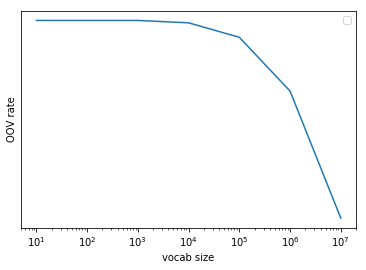

In [7]:
ov.plot_oov_rates(oov_rates)

##### tuned char-model

In [8]:
GEN_DATA_PATH = "data/generated/hd150_cl50_3_bng_tr_chr_50/"
MODEL_PATH = f"./rnnlm_models/hd150_cl50_3_bng_tr_chr_50"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [10]:
# Decoding generated texts
sentpiece.desegmentation("data/generated/hd150_cl50_3_bng_tr_chr_50/100.txt", "bng_train_50")

In [15]:
dir_path="data/generated/hd150_cl50_3_bng_tr_chr_50/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_50")
        
    add_vocab = ov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = ov.compute_oov_rate(ov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

10
100
1000
10000
100000
1000000
10000000
{10: 0.13434656741108353, 100: 0.13434656741108353, 1000: 0.13434656741108353, 10000: 0.13424317617866005, 100000: 0.13306451612903225, 1000000: 0.1260545905707196, 10000000: 0.11126964433416046}


No handles with labels found to put in legend.


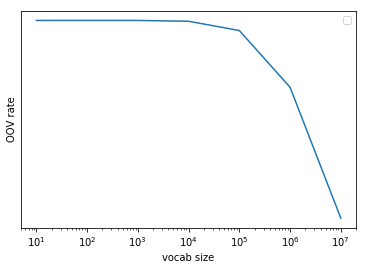

In [14]:
ov.plot_oov_rates(oov_rates)

### baseline small word-level model

In [5]:
GEN_DATA_PATH = "data/generated/bng_tr_chr_100"#"data/generated/hd40_cl9999_3_bng_tr_chr_600/"
MODEL_PATH = f"./rnnlm_models/bng_tr_chr_100"

from pathlib import Pat5                                                                                                                        h
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [9]:
# inspect 100.txt
sentpiece.desegmentation("data/generated/bng_tr_chr_100/100.txt", "bng_train_100")

##### OOV comparison

In [11]:
train_vocab, test_vocab = ov.get_vocab(TRAIN_DATA_PATH), ov.get_vocab(TEST_DATA_PATH) 

dir_path="data/generated/bng_tr_chr_100/" #"data/generated/hd40_cl9999_3_bng_tr_chr_600/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_100")
        
    add_vocab = ov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = ov.compute_oov_rate(ov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

10
100
1000
10000
100000
1000000
10000000
{10: 0.13434656741108353, 100: 0.13430521091811415, 1000: 0.13428453267162946, 10000: 0.13409842845326717, 100000: 0.13221670802315963, 1000000: 0.1248759305210918, 10000000: 0.11226220016542597}


No handles with labels found to put in legend.


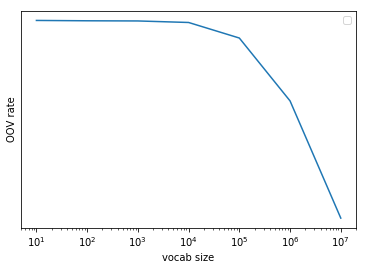

In [12]:
ov.plot_oov_rates(oov_rates)

### tuned small word-level model

In [13]:
GEN_DATA_PATH = "data/generated/hd200_cl100_3_bng_tr_chr_100/" #hd200_cl600_3_bng_tr_chr_600/"
MODEL_PATH = f"./rnnlm_models/hd200_cl100_3_bng_tr_chr_100" #hd200_cl600_3_bng_tr_chr_600"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [14]:
# inspect 100.txt
sentpiece.desegmentation("data/generated/hd200_cl100_3_bng_tr_chr_100/100.txt", "bng_train_100")

##### OOV comparison

In [15]:
train_vocab, test_vocab = ov.get_vocab(TRAIN_DATA_PATH), ov.get_vocab(TEST_DATA_PATH) 

dir_path="data/generated/hd200_cl100_3_bng_tr_chr_100/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_100")
        
    add_vocab = ov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = ov.compute_oov_rate(ov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

10
100
1000
10000
100000
1000000
10000000
{10: 0.13434656741108353, 100: 0.13432588916459884, 1000: 0.13426385442514474, 10000: 0.13399503722084366, 100000: 0.13194789081885855, 1000000: 0.12334574028122415, 10000000: 0.1065136476426799}


No handles with labels found to put in legend.


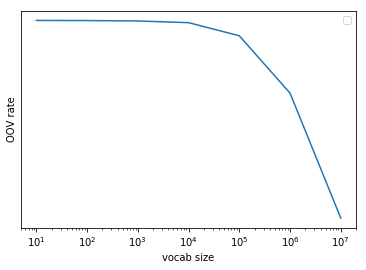

In [16]:
ov.plot_oov_rates(oov_rates)

### large word-level model

#### baseline

In [9]:
GEN_DATA_PATH = "data/generated/bng_tr_wd_1500/"
MODEL_PATH = f"./rnnlm_models/bng_tr_wd_1500"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [10]:
# inspect 100.txt
sentpiece.desegmentation("data/generated/bng_tr_wd_1500/100.txt", "bng_train_1500")

##### OOV comparison

In [11]:
train_vocab, test_vocab = ov.get_vocab(TRAIN_DATA_PATH), ov.get_vocab(TEST_DATA_PATH) 

dir_path="data/generated/bng_tr_wd_1500/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_1500")
        
    add_vocab = ov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = ov.compute_oov_rate(ov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

10
100
1000
10000
100000
1000000
10000000
{10: 0.13434656741108353, 100: 0.13434656741108353, 1000: 0.13432588916459884, 10000: 0.13395368072787428, 100000: 0.13091397849462366, 1000000: 0.12022332506203474, 10000000: 0.10256410256410256}


No handles with labels found to put in legend.


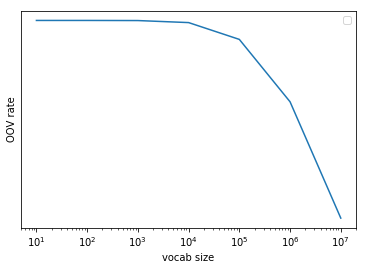

In [12]:
ov.plot_oov_rates(oov_rates)

### tuned large word model

In [13]:
GEN_DATA_PATH = "data/generated/hid50_bng_tr_wd_1500/"
MODEL_PATH = f"./rnnlm_models/hid50_bng_tr_wd_1500"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [14]:
# inspect 100.txt
sentpiece.desegmentation("data/generated/hid50_bng_tr_wd_1500/100.txt", "bng_train_1500")

##### OOV comparison

In [15]:
train_vocab, test_vocab = ov.get_vocab(TRAIN_DATA_PATH), ov.get_vocab(TEST_DATA_PATH) 

dir_path="data/generated/hid50_bng_tr_wd_1500/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_1500")
        
    add_vocab = ov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = ov.compute_oov_rate(ov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

10
100
1000
10000
100000
1000000
10000000
{10: 0.13434656741108353, 100: 0.13434656741108353, 1000: 0.13430521091811415, 10000: 0.13391232423490487, 100000: 0.13122415219189412, 1000000: 0.12107113316790737, 10000000: 0.10206782464846981}


No handles with labels found to put in legend.


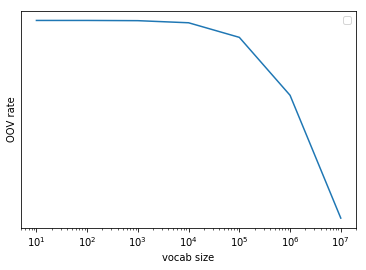

In [16]:
ov.plot_oov_rates(oov_rates)

In [15]:
# Observations from generated LM
sentpiece.show_desegmented_file("data/generated/bng_chr_50/100_desegmented.txt")
sentpiece.show_desegmented_file("data/generated/bng_tr_chr_100/100_desegmented.txt")
sentpiece.show_desegmented_file("data/generated/bng_tr_wd_1500/100_desegmented.txt")
sentpiece.show_desegmented_file("data/generated/hd150_cl50_3_bng_tr_chr_50/100_desegmented.txt")
sentpiece.show_desegmented_file("data/generated/hd200_cl100_3_bng_tr_chr_100/100_desegmented.txt")
sentpiece.show_desegmented_file("data/generated/hid50_bng_tr_wd_1500/100_desegmented.txt")

bng_chr_50
প্রকার ভিলতে ৷ত্কার নায়মে সে বিচারা করে আজদেরকে বছর্তার হাকিবেশ সাস্তি দেশে অনেক হিচাই দলাম করিস্প
bng_tr_chr_100
ঘরনা করতে বাংলাদে ভিপূরুভা দেহএবং গোতের বাসাল আইপ্রমাজ এম নাম রাষ্যা খুবি ধদি করবেন কার্র ১০০স্ডার জরে নাইট দায়ের কোনযতবার ও হুখা যাতে পিতে মায়া নি
bng_tr_wd_1500
ষড়ই লেগে নিসে তার জনপনা মারতে আসেনাএই ধরনের মোম্ম্বালা মিন্নি সব সোযত তাই না এ সরকারী ডিসির পিছন আর একটা খারাপ আর কেন উঠেছে একজন ফাসি চাই ভাইআসলে গেম হলেও কে বলছি আনি লেয়েলতা হবে পতিতা আরেকটা জ্বলা আমার গু ম্যাজি রুবেলের সাথে সঝজব করুন তার বাজে গাঁ সবার মানুষগুলোরলিগার রিকামুর দৃত্যে কোন কথা কি চোখে
hd150_cl50_3_bng_tr_chr_50
তার মেয়ে চুবু,,আমার চাকরি অাবন্ধ করেতোর সাবের ছিব তাহেমিকের মত মতো বলে সবার জন্য জপ্রাটকন্যাবাদুকী
hd200_cl100_3_bng_tr_chr_100
কাজলাথ ছিনো আছি আপনার প্লদ আছে এটিকে রাজ না এর সাথে ও এত ছিলো..._ক্ষে আড়ালি সুরাত কাজ করে ও ঘোটা দেখা খুশি প্রাণী ফুটবল যখন রোপো
hid50_bng_tr_wd_1500
এঙ্গারছাগলএডরিভারতে চাই সে জীবন দেখেননাসে যিনি আদরত্যা করোআমি বলছি মনে হয় নারুবেল দিনের কোন মিডিয়

##Do you see a difference in the quality of the generated data? Why could that be?

### Observations


#### baseline models

| Language |   Level   | Voc. size | Hyperparams (hid-class-bptt) | Perplexity | OOV rate % (BS: 13.43%) |
|:--------:|:---------:|:---------:|:--------------------------:|:----------:|:-------------------:|
|  Bengali | Character |     50    |          40-9999-3         |  9.782082  |        11.53        |
|  Bengali |   Small   |    100    |          40-9999-3         |  23.861190 |        11.22        |
|  Bengali |   Large   |    1500   |          40-9999-3         | 319.937888 |        10.26        |

#### tuned models 
| Language |   Level   | Voc. size | Hyperparams (hid-class-bptt) | Perplexity | OOV rate % (BS: 13.43%) |
|:--------:|:---------:|:---------:|:--------------------------:|:----------:|:--------------------:|
|  Bengali | Character |     50    |          150-50-3          |  7.537116  |         11.13        |
|  **Bengali** |   **Small**   |    **100**    |          **200-100-3**         |  **17.242739** |         **10.65**        |
|  Bengali |   Large   |    1500   |          50-9999-3         | 315.655359 |         10.21        |


As expected, the added vocabulary from language models lowers the OOV rate. Across all models, the highest difference in oov rate is observed with the 10^7-sized LM generated output. So, for comparison with the baseline, we consider the OOV-rate corresponding to this augmentation. <br>
The baseline OOV rate of 13.43% goes down to 11.13% with character-level tuned LM. It is further reduced to 10.65% and 10.21% with tuned small and large word-level LMs, respectively. However, we can clearly observe that the reduced OOV rates come at the price of increasing perplexity. <br>
As the vocab-size of the LM increases, perplexity increases at a much faster rate than OOV rate. Experiments with vocab size larger than 1500 (eg. with vocab size 2500) showed perplexities as high as 460.93 for baseline and 457.38 for the tuned model. But there wasn't a significant difference in its OOV rate as compared to the 1500-vocab-sized model (10.19% for baseline and 10.16% for tuned). <br>
**For practical purposes, we would choose the the tuned small word-level model, since it gives both a decent perplexity and a decent OOV-rate as compared to the other models.**  

# Analysis

##### what we aimed to achieve
The goal of this project was to find optimal subwords and train a language model over these subwords to alleviate the OOV problem in two morphologically distinct languages: English and Bengali. This was done by augmenting the train data with the data generated by trained language models and finding the optimal OOV rate on the test set using the augmented train corpora.  <br>

###### summary of our observations for all tasks 
1. Data Preparation: After manually inspecting both corpora, following preprocessing steps are done: 

    For English:
        - Simple noise removal: asterisk (*) symbols are removed, sequences ‘_I_’ are substituted with the character ‘I’ and sequences ‘--’ are substituted with whitespaces.
        - Lowercasing: In order to reduce vocabulary size, however, we should experiment and test results without lowercasing.
        - Other methods (e.g. stemming, stopwords removal, expendin contractions) are not used since it is a language modeling task and we want to preserve language style.  

    For Bengali:
        - Line break html tags are used to segment text, which is further broken down into smaller sentences using punctuations "।!?".
        - Simple noise removal from sentences: English words/characters, numbers, html tags and emoji flags are removed. 


2. Subword Segmentation  
For Bengali, 

3. LM Training


###### whether our expectations were fulfilled  
Yes, we achieved significantly lower OOV-rates than the baseline with our models. 

##### takeaways from this project 


##### how do results differ for English and Bengali


##### hyperparameters we use to optimize the OOV rates 



##### ways to further improve results 